In [1]:
import numpy as np 
from gcs import path_handler as ph 
import gcs
import tstrippy
import matplotlib.pyplot as plt
import os 

In [2]:
# Configure Matplotlib to use LaTeX for text rendering
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",  # Use 'serif' or specify the exact font family
    "font.serif": ["Times New Roman"],  # Replace with the font used in your LaTeX document
    "axes.labelsize": 12,  # Font size for axis labels
    "font.size": 12,  # General font size
    "legend.fontsize": 12,  # Font size for legend
    "xtick.labelsize": 12,  # Font size for x-axis tick labels
    "ytick.labelsize": 12,  # Font size for y-axis tick labels
})

In [3]:
dark=False
potential="pouliasis2017pii"
montecarlokey="monte-carlo-000"
results_path=ph.paths['simulations'] + "/ImpactGeometry/pouliasis2017pii-GCNBody/Pal5"+"/AllImpactGeometryByHandAndEye.csv"

In [4]:
if dark==True:
    plt.style.use('dark_background')
    outname="E_Lz_perturbers_dark.png"
    outname2="Pal5_radial_coordinate_with_perturbers_dark.png"
    outname3="mass_size_plane_dark.png"
else:
    outname="E_Lz_perturbers.png"
    outname2="Pal5_radial_coordinate_with_perturbers.png"
    outname3="mass_size_plane.png"

outdir="/home/sferrone/plots/stream_analysis/notebooks/impact_statistics/"
os.makedirs(outdir,exist_ok=True)


In [5]:
# Assuming the CSV file has a header
data = np.genfromtxt(results_path, delimiter=',', names=True, dtype=None, encoding='utf-8')

# Extract each column into a separate numpy array
column_names = data.dtype.names
columns = {name: data[name] for name in column_names}
# Example: Accessing individual columns
impact_parameter = columns['impact_parameter']
gap_flag = columns['gap_flag']
suspects=columns['suspect']
montecarlokey = columns["montecarlokey"]
Mass=columns['Mass']
rplum=columns['rplum']
guilty=np.unique(suspects[gap_flag])
tau=columns['tau']
Time=columns['T']

In [6]:
GCnames=tstrippy.Parsers.baumgardtMWGCs().data['Cluster']

In [7]:
guilty_ids=[np.where(GCnames==guilty[i])[0][0] for i in range(len(guilty))]
pal5ID = np.where(GCnames=="Pal5")[0][0]

In [8]:
import h5py 
i=10
myfile=h5py.File(ph.GC_orbits(potential,GCnames[i]),"r")
myfile.keys()

<KeysViewHDF5 ['monte-carlo-000', 'monte-carlo-001', 'monte-carlo-002', 'monte-carlo-003', 'monte-carlo-004', 'monte-carlo-005', 'monte-carlo-006', 'monte-carlo-007', 'monte-carlo-008', 'monte-carlo-009', 'monte-carlo-010', 'monte-carlo-011', 'monte-carlo-012', 'monte-carlo-013', 'monte-carlo-014', 'monte-carlo-015', 'monte-carlo-016', 'monte-carlo-017', 'monte-carlo-018', 'monte-carlo-019', 'monte-carlo-020', 'monte-carlo-021', 'monte-carlo-022', 'monte-carlo-023', 'monte-carlo-024', 'monte-carlo-025', 'monte-carlo-026', 'monte-carlo-027', 'monte-carlo-028', 'monte-carlo-029', 'monte-carlo-030', 'monte-carlo-031', 'monte-carlo-032', 'monte-carlo-033', 'monte-carlo-034', 'monte-carlo-035', 'monte-carlo-036', 'monte-carlo-037', 'monte-carlo-038', 'monte-carlo-039', 'monte-carlo-040', 'monte-carlo-041', 'monte-carlo-042', 'monte-carlo-043', 'monte-carlo-044', 'monte-carlo-045', 'monte-carlo-046', 'monte-carlo-047', 'monte-carlo-048', 'monte-carlo-049']>

In [9]:
def snap_all_init_cond_per_GC(fname):
    with h5py.File(fname,"r") as myfile:
        x  = np.array([myfile["monte-carlo-"+str(j).zfill(3)]['xt'][0] for j in range(50)])
        y  = np.array([myfile["monte-carlo-"+str(j).zfill(3)]['yt'][0] for j in range(50)])
        z  = np.array([myfile["monte-carlo-"+str(j).zfill(3)]['zt'][0] for j in range(50)])
        vx = np.array([myfile["monte-carlo-"+str(j).zfill(3)]['vxt'][0] for j in range(50)])
        vy = np.array([myfile["monte-carlo-"+str(j).zfill(3)]['vyt'][0] for j in range(50)])
        vz = np.array([myfile["monte-carlo-"+str(j).zfill(3)]['vzt'][0] for j in range(50)])
        return x,y,z,vx,vy,vz

In [10]:
def allensantillianhalo(params,x,y,z):
    G = params[0]
    M= params[1]
    a = params[2]
    gamma = params[3]
    rcut = params[4]

    r = np.sqrt(x**2+y**2+z**2)
    beyond = r>rcut

    massMod = M*(r/a)**gamma
    massMod = massMod/(1+(r/a)**(gamma-1))
    amod = G*massMod/r**3
    ax,ay,az = -amod*x,-amod*y,-amod*z

    # update for the case where r>rcut
    mtotal = M*(rcut/a)**gamma / (1+(rcut/a)**(gamma-1))
    amod = G*mtotal/rcut**3
    ax[beyond],ay[beyond],az[beyond] = -amod*x[beyond],-amod*y[beyond],-amod*z[beyond]

    phic = -(G*mtotal/rcut) - (G*M/a) * np.log(1 + (rcut/a)**(gamma-1))
    phi = (G*M/a) * np.log(1 + (r/a)**(gamma-1)) +phic

    phi[beyond] =  -(G*mtotal/r[beyond]) 

    return ax,ay,az,phi


def correctedhalo(MWparams,x,y,z):
    haloparms = [*MWparams[0:5]]
    disk1params = [MWparams[0],*MWparams[5:8]]
    disk2params = [MWparams[0],*MWparams[8:]]
    phi = allensantillianhalo(haloparms,x,y,z)[3]
    phi1 = tstrippy.potentials.miyamotonagai(disk1params,x,y,z)[3]
    phi2 = tstrippy.potentials.miyamotonagai(disk2params,x,y,z)[3]
    return phi+phi1+phi2



In [11]:
def snap_all_init_cond_per_GC(fname, nmontecarlo=50):
    with h5py.File(fname, "r") as myfile:
        x = np.zeros(nmontecarlo)
        y = np.zeros(nmontecarlo)
        z = np.zeros(nmontecarlo)
        vx = np.zeros(nmontecarlo)
        vy = np.zeros(nmontecarlo)
        vz = np.zeros(nmontecarlo)
        
        for j in range(nmontecarlo):
            group = myfile[f"monte-carlo-{str(j).zfill(3)}"]
            x[j] = group['xt'][0]
            y[j] = group['yt'][0]
            z[j] = group['zt'][0]
            vx[j] = group['vxt'][0]
            vy[j] = group['vyt'][0]
            vz[j] = group['vzt'][0]
        
        return x, y, z, vx, vy, vz


MWparams=tstrippy.Parsers.potential_parameters.pouliasis2017pii()
nmontecarlo=50
phase_space=np.zeros((len(GCnames),6))
V = np.zeros((len(GCnames),nmontecarlo))
T = np.zeros((len(GCnames),nmontecarlo))
Lz = np.zeros((len(GCnames),nmontecarlo))
for i in range(len(GCnames)):
    if np.mod(i,10)==0:
        print(GCnames[i])
    x,y,z,vx,vy,vz=snap_all_init_cond_per_GC(ph.GC_orbits(potential,GCnames[i]))
    # _,_,_,phi=tstrippy.potentials.pouliasis2017pii(MWparams,x,y,z)
    phi=correctedhalo(MWparams,x,y,z)
    V[i]=phi
    T[i]=0.5*(vx**2+vy**2+vz**2)
    Lz[i] = x*vy-y*vx

NGC104
NGC1904
NGC4147
NGC5286
NGC5927
NGC6139
NGC6256
NGC6304
Ter2
NGC6388
NGC6441
Ter10
ESO280-SC06
NGC6626
NGC6717
Ter8
NGC7089


In [20]:
E = T.flatten() + V.flatten()
Lzz=Lz.flatten()

In [13]:
num_objects=len(GCnames)
# Get a colormap
cmap = plt.get_cmap('rainbow')
# Generate a list of unique colors
colors = [cmap(i / num_objects) for i in range(num_objects)]
# Define a list of marker styles
markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'h', 'H', '+', 'x', 'd', '|', '_']


In [18]:
AXIS=dict(xlabel=r"$L_z$ [kpc km/s]",
          ylabel=r"$E$ [km$^2$/s$^2$]",
          xlim=[-5000,5000])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


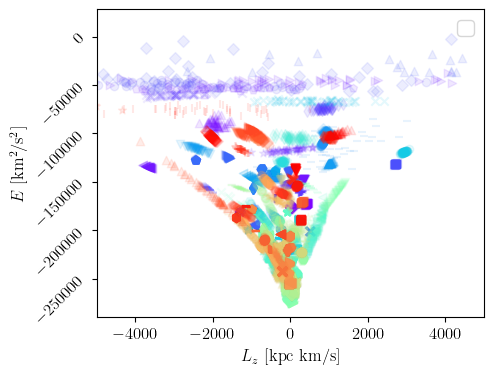

In [25]:

fig,ax=plt.subplots(1,1,figsize=(5,4))
# i=18
for i in range(num_objects):
    marker = markers[i % len(markers)]  # Cycle through markers
    ax.scatter(Lz[i][:],T[i]+V[i],color=colors[i],alpha=0.1,marker=marker)
# ax.scatter(Lz[guilty_ids],T[guilty_ids]+V[guilty_ids],color='red',label="Perturbers")
# ax.scatter(Lz[pal5ID],T[pal5ID]+V[pal5ID],color='green',s=100,label="Pal5")
ax.set(**AXIS)
ax.tick_params(axis='y', rotation=45)  # Rotate y-axis ticks by 45 degrees
ax.legend(fontsize=15)


In [155]:
np.unravel_index(np.argmax(E),T.shape)


0

In [178]:
t,x,y,z,vx,vy,vz=gcs.extractors.GCOrbits.extract_whole_orbit(ph.GC_orbits(potential,GCnames[19]),"monte-carlo-044")

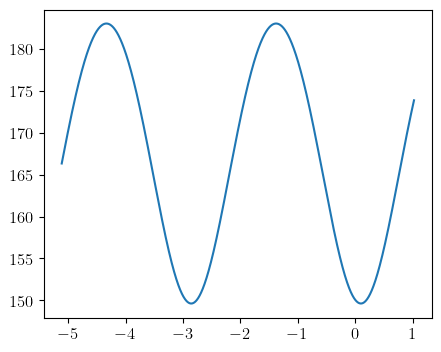

In [179]:
fig,axis=plt.subplots(1,1,figsize=(5,4))
axis.plot(t,np.sqrt(x**2+y**2+z**2))

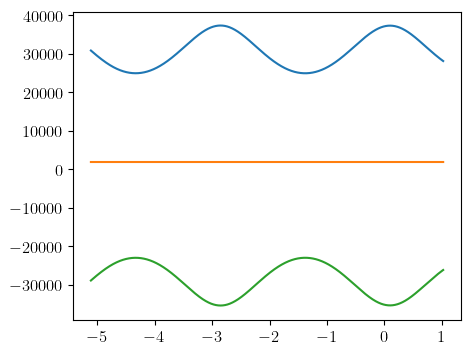

In [186]:
Vt = tstrippy.potentials.pouliasis2017pii(MWparams,x,y,z)[3]
KEt=0.5*(vx**2+vy**2+vz**2)
fig,axis=plt.subplots(1,1,figsize=(5,4))
axis.plot(t,KEt)
axis.plot(t,KEt+Vt)
axis.plot(t,Vt)

In [268]:
def allensantillianhalo(params,x,y,z):
    G = params[0]
    M= params[1]
    a = params[2]
    gamma = params[3]
    rcut = params[4]

    r = np.sqrt(x**2+y**2+z**2)
    beyond = r>rcut

    massMod = M*(r/a)**gamma
    massMod = massMod/(1+(r/a)**(gamma-1))
    amod = G*massMod/r**3
    ax,ay,az = -amod*x,-amod*y,-amod*z

    # update for the case where r>rcut
    mtotal = M*(rcut/a)**gamma / (1+(rcut/a)**(gamma-1))
    amod = G*mtotal/rcut**3
    ax[beyond],ay[beyond],az[beyond] = -amod*x[beyond],-amod*y[beyond],-amod*z[beyond]

    phic = -(G*mtotal/rcut) - (G*M/a) * np.log(1 + (rcut/a)**(gamma-1))
    phi = (G*M/a) * np.log(1 + (r/a)**(gamma-1)) +phic

    phi[beyond] =  -(G*mtotal/r[beyond]) 

    return ax,ay,az,phi


1000
1000
1000


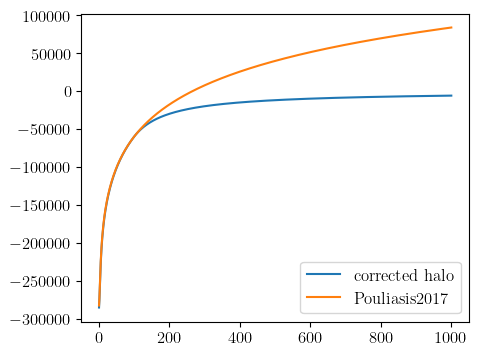

In [311]:
r = np.linspace(0.1,1000,1000)
VPHI = tstrippy.potentials.pouliasis2017pii(MWparams,r,np.zeros_like(r),np.zeros_like(r))[3]
myphi = correctedhalo(MWparams,r,np.zeros_like(r),np.zeros_like(r))
fig,axis=plt.subplots(1,1,figsize=(5,4))
axis.plot(r,myphi,label="corrected halo")
axis.plot(r,VPHI,label="Pouliasis2017")
axis.legend()

In [275]:
mtotal = M*(rcut/a)**gamma * (1 + (rcut/a)**(gamma-1))**(-1)

In [276]:
print((rcut/a)**gamma * (1 + (rcut/a)**(gamma-1))**-1)

6.295475357194757


ValueError: x and y must have same first dimension, but have shapes (100,) and (1000,)

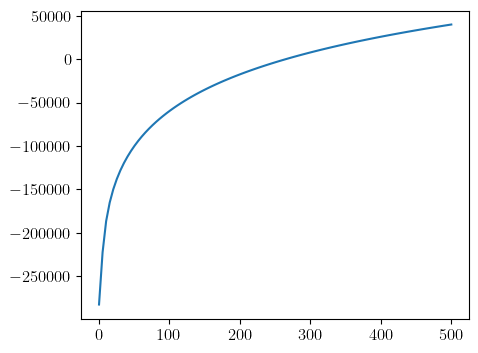

In [278]:
r=np.linspace(.1,500,100)

fig,axis=plt.subplots(1,1,figsize=(5,4))
axis.plot(r,VPHI)
axis.plot(r,phi)